### Preamble
- In this notebook, we use samples to train a binary classifier on synthetic data

In [1]:
import gpflow
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from tensorflow.python import linalg as tfla
from gpflow.config import default_jitter, default_float as floatx
from gpflow_sampling.models import PathwiseSVGP

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', size=12)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'''
       \usepackage{amsmath,amsfonts}
       \renewcommand{\v}[1]{\boldsymbol{#1}}''')
plt.rc('figure', dpi=256)

In [3]:
tf.random.set_seed(1)

### Generate toy data

In [4]:
kernel = gpflow.kernels.Matern52(lengthscales=0.1)
likelihood = gpflow.likelihoods.Bernoulli()

xmin = 0.15  # range over which we observe
xmax = 0.50  # the behavior of a function $f$
X = tf.convert_to_tensor(np.linspace(xmin, xmax, 1024)[:, None])

K = kernel(X, full_cov=True)
L = tfla.cholesky(tfla.set_diag(K, tfla.diag_part(K) + default_jitter()))
f = L @ tf.random.normal([len(X), 1], dtype=floatx())
p = likelihood.invlink(f)
y = tf.cast(tf.random.uniform(p.shape, dtype=p.dtype) <= p, floatx())  # binary labels

### Initialize model

In [5]:
class CustomPathwiseSVGP(PathwiseSVGP):
    def elbo(self, data: tuple, num_samples: int = 16, num_bases: int = 1024) -> tf.Tensor:
        """
        Estimate the evidence lower bound on the log marginal likelihood of the model 
        by using decoupled sampling to construct a Monte Carlo integral.
        """
        X, y = data
        with self.temporary_paths(num_samples=num_samples, num_bases=num_bases):
            f = self.predict_f_samples(X)
            
        if hasattr(self.likelihood, 'invlink'):
            f = self.likelihood.invlink(f)
        
        kl = self.prior_kl()
        monte_carlo = tf.reduce_mean(self.likelihood.log_prob(f, y), axis=0)
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)

        return tf.reduce_sum(monte_carlo) * scale - kl

In [6]:
Z = np.linspace(xmin, xmax, 8)[:, None]
model = CustomPathwiseSVGP(kernel=kernel,
                           likelihood=likelihood,
                           inducing_variable=Z,
                           num_data=len(y))

# Keep things sane since we don't have a lot of data, 
gpflow.utilities.set_trainable(model.kernel, False)

### Sample-based training 

In [7]:
num_steps = 1000
step_sizes = [1e-2, 1e-3, 1e-4]
boundaries = [k * num_steps//len(step_sizes) for k in range(1, len(step_sizes))]
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, step_sizes)
optimizer = tf.keras.optimizers.Adam(schedule)

closure = model.training_loss_closure(data=(X, y))
trainables = model.trainable_variables
step_iterator = tqdm(range(num_steps))

for step in step_iterator:
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(trainables)
        loss = closure()
    
    grads = tape.gradient(loss, trainables)
    grads_and_vars = tuple(zip(grads, trainables))
    optimizer.apply_gradients(grads_and_vars)
    loss_ema = loss if (step == 0) else loss_ema + 0.25 * (loss - loss_ema)
    step_iterator.set_postfix_str(f'EMA(loss): {loss_ema:.3e}')

100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s, EMA(loss): 6.559e+02]


### Visualize

In [8]:
Xnew = tf.linspace(tf.cast(0.0, floatx()), tf.cast(1.0, floatx()), 1024)
mu, sigma2 = map(tf.squeeze, model.predict_f(Xnew[:, None]))
with model.temporary_paths(num_samples=10000, num_bases=1024) as temp_paths:
    fnew = tf.squeeze(model.predict_f_samples(Xnew[:, None]))
pnew = model.likelihood.invlink(fnew)

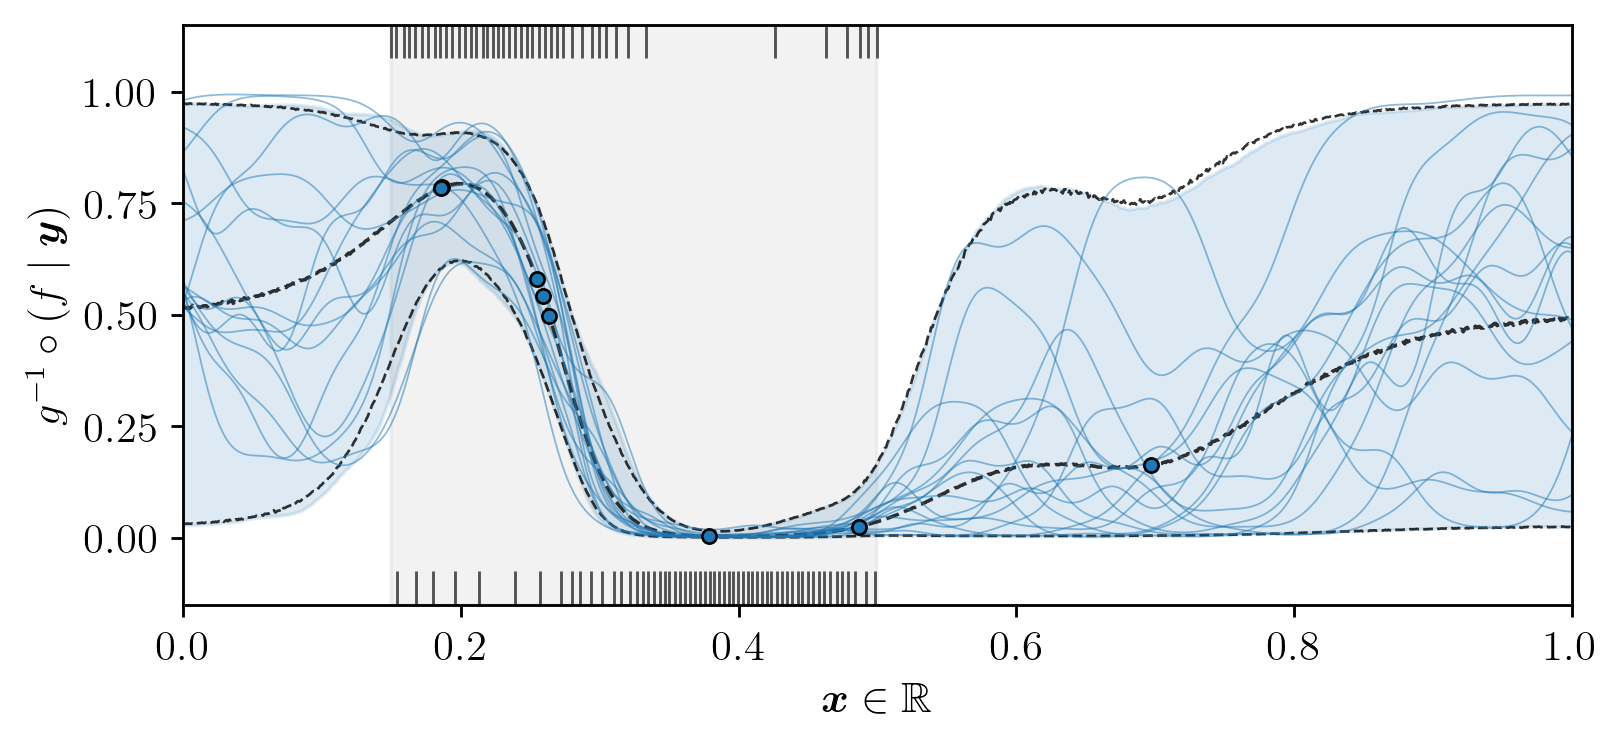

In [9]:
fig, ax = plt.subplots(figsize=(7, 3))
lower = tf.cast(0.025, floatx())
upper = tf.cast(0.975, floatx())

# Visualize the training data
label_height = 0.075
ylim = -2 * label_height, 1 + 2 * label_height
_ = ax.fill_between([xmin, xmax], *ylim, zorder=0, color='silver', alpha=0.2)

for class_id in (0, 1):  # show every tenth label
    hits = tf.where(tf.squeeze(y == class_id))[::10, 0]
    _X = np.squeeze(tf.gather(X, hits))
    _y = np.full([len(_X)], 1 + label_height if class_id else -label_height)
    ax.scatter(_X,
               _y,
               marker=2 if class_id else 3,
               color='k',
               s=128,
               linewidth=0.8,
               alpha=2/3)

# Estimate ground truth quantiles
_f = mu + tf.sqrt(sigma2) * tf.random.normal([2 ** 16, len(mu)], dtype=mu.dtype)
_p = model.likelihood.invlink(_f)
pl, pm, pu = np.quantile(_p, q=[lower, 0.5, upper], axis=0)
ax.plot(Xnew, pm , '--k', linewidth=1.0, alpha=0.8)
ax.plot(Xnew, pl, '--k', linewidth=0.75, alpha=0.8)
ax.plot(Xnew, pu, '--k', linewidth=0.75, alpha=0.8)

# Show empirical quantiles
ax.fill_between(Xnew, 
                *np.quantile(pnew, q=(lower, upper), axis=0), 
                color='tab:blue', 
                alpha=0.15)

# Visualize some sample paths
for probs in pnew[:16]:
    ax.plot(Xnew, probs, alpha=0.5, linewidth=0.5, color='tab:blue')
    
# Plot inducing locations and means
Z = model.inducing_variable.variables[0].numpy()
q_mu = model.q_mu.numpy()
if model.whiten:
    Luu = tf.linalg.cholesky(model.kernel(Z, full_cov=True))
    q_mu = Luu @ q_mu
ax.scatter(Z, 
           model.likelihood.invlink(q_mu),
           zorder=9999, # place these on top
           s=16, 
           color='tab:blue',
           linewidth=0.75,
           edgecolor='k')

# Format axes
_ = ax.set_xlim(0, 1)
_ = ax.set_xlabel(r'$\v{x} \in \mathbb{R}$')
_ = ax.set_ylim(ylim)
_ = ax.set_ylabel(r'$g^{-1} \circ (f \mid \v{y})$')